In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pickle
import os
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from importlib import reload

import sys
sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/t-recs')
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo
import src.globals as globals
import seaborn as sns

from wrapper.models.bubble import BubbleBurster
from src.utils import *
from src.plotting import plot_measurements 
from src.scoring_functions import cosine_sim, entropy, content_fairness, cosine_sim2
from wrapper.metrics.evaluation_metrics import *

random_state = np.random.seed(42)
plt.style.use("seaborn")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

globals.initialize()

/var/folders/sm/hcy50x855gvf2b1qwkjstnvh0000gn/T/ipykernel_27082/2028533230.py:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


# RecommenderSystem on MovieLens 

In [2]:
n_attrs=20
max_iter=1000
n_clusters=25

In [3]:
score_fn = 'cosine_sim2'
probabilistic = False
globals.ALPHA = 0.1
alpha = globals.ALPHA

# User parameters
drift = 0.05
attention_exp=-0.8

## Embeddings

In [4]:
binary_ratings_matrix = load_and_process_movielens(file_path='/Users/madisonthantu/Desktop/DREAM/data/ml-100k/u.data')

In [5]:
# Get user and item representations using NMF
user_representation, item_representation = create_embeddings(binary_ratings_matrix, n_attrs=n_attrs, max_iter=max_iter)

Loaded embeddings.


In [6]:
# Define topic clusters using NMF
item_cluster_ids, item_cluster_centers = get_clusters(item_representation.T, name='item', n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)
user_cluster_ids, user_cluster_centers = get_clusters(user_representation, name='user', n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)

/Users/madisonthantu/miniforge3/envs/fairRS/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator KMeans from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded clusters.
Loaded clusters.


/Users/madisonthantu/miniforge3/envs/fairRS/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator KMeans from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Model

In [7]:
num_users = len(user_representation)
num_items = len(item_representation)
print(f'Number of items: {num_items}')
print(f'Number of users: {num_users}')

users = Users(actual_user_profiles=user_representation, 
              repeat_interactions=False, 
              drift=drift,
              attention_exp=attention_exp)

Number of items: 20
Number of users: 943


In [8]:
# Create user_pairs by pairing users only with others that are not in the same cluster
user_item_cluster_mapping = user_topic_mapping(user_representation, item_cluster_centers) # TODO: Remove?
experiment_name = 'users_by_topic'
# Create user_pairs by pairing users only with others that are not in the same cluster
inter_cluster_user_pairs, intra_cluster_user_pairs = create_cluster_user_pairs(user_item_cluster_mapping)

In [9]:
mse = MSEMeasurement()
measurements = [
    InteractionMeasurement(),
    MSEMeasurement(),  
    # InteractionSpread(),                
    # InteractionSimilarity(pairs=inter_cluster_user_pairs, name='inter_cluster_interaction_similarity'), 
    # InteractionSimilarity(pairs=intra_cluster_user_pairs, name='intra_cluster_interaction_similarity'), 
    # RecSimilarity(pairs=inter_cluster_user_pairs, name='inter_cluster_rec_similarity'), 
    # RecSimilarity(pairs=intra_cluster_user_pairs, name='intra_cluster_rec_similarity'), 
    # UserMSEMeasurement(),
    # SerendipityMetric(), 
    # DiversityMetric(), 
    # NoveltyMetric(),
    # RecallMeasurement(),
    # MeanNumberOfTopics(),
    CosineSim(),
]

In [10]:
# Model
config = {
    'actual_user_representation': users,
    'actual_item_representation': item_representation,
    'item_topics': item_cluster_ids,
    'num_attributes': n_attrs,
    'num_items_per_iter': 10,
    'seed': 42,
    'record_base_state': True,
}

model_name='myopic'
requires_alpha = False

if score_fn:
    if score_fn == 'cosine_sim2':
        config['score_fn'] = cosine_sim2
    elif score_fn == 'cosine_sim':
        config['score_fn'] = cosine_sim
        requires_alpha = True
    elif score_fn == 'entropy':
        config['score_fn'] = entropy
        requires_alpha = True
    elif score_fn == 'content_fairness':
        config['score_fn'] = content_fairness        
    else:
        raise Exception('Given score function does not exist.')
    assert(config['score_fn'] == cosine_sim2)
    model_name = score_fn

if probabilistic:
    config['probabilistic_recommendations'] = True
    model_name += '_prob'

In [11]:
model = BubbleBurster(**config)

model.add_metrics(*measurements)

/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research/src/scoring_functions.py:46: RuntimeWarning: invalid value encountered in divide
  cos_sim = numerator / denominator
/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research/wrapper/metrics/evaluation_metrics.py:332: RuntimeWarning: invalid value encountered in divide
  cos_sim = numerator / denominator


## Simulation

In [12]:
# Fair Model
train_timesteps=5
model.startup_and_train(timesteps=train_timesteps)

100%|██████████| 5/5 [00:00<00:00, 23.28it/s]


In [13]:
run_timesteps=20
model.run(timesteps=run_timesteps)

100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


In [14]:
import src
reload(src.utils)
from src.utils import *
    
# Determine file name based on parameter values
parameters = f'_{train_timesteps}trainTimesteps_{run_timesteps}runTimesteps_{n_attrs}nAttrs_{n_clusters}nClusters_{drift}Drift_{attention_exp}AttentionExp'
if requires_alpha:
    parameters += f'_{alpha}Lambda'

# Save actual user preferences
final_preferences_dir = 'artefacts/final_preferences/'
file_prefix = f'{model_name}_final_preferences'
final_preferences_path = final_preferences_dir + file_prefix + parameters + '.npy'
np.save(final_preferences_path, model.users.actual_user_profiles.value, allow_pickle=True)

# Save measurements
measurements_dir = f'artefacts/measurements/'
file_prefix = f'{model_name}_measurements'

measurements_path = measurements_dir + file_prefix + parameters + '.csv'
measurements_df = load_or_create_measurements_df(model, model_name, train_timesteps, measurements_path)
measurements_df.to_csv(measurements_path)
print('Measurements saved.')

Measurements saved.


In [20]:
measurements_path

'artefacts/measurements/cosine_sim2_measurements_5trainTimesteps_20runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp.csv'

## Analysis

In [15]:
# Create df for parameters
numeric_cols = ['trainTimesteps', 'runTimesteps', 'nAttrs', 'nClusters', 'Lambda']
columns = ['model_name'] + numeric_cols

data = [[model_name, train_timesteps, run_timesteps, n_attrs, n_clusters, None]]
if requires_alpha:
    data = [[model_name, train_timesteps, run_timesteps, n_attrs, n_clusters, alpha]]

parameters_df = pd.DataFrame(data,
                             columns = columns)
for col in numeric_cols:
    parameters_df[col] = pd.to_numeric(parameters_df[col])

In [19]:
parameters_df

,model_name,trainTimesteps,runTimesteps,nAttrs,nClusters,Lambda
0,cosine_sim2,5,20,20,25,NaN


In [16]:
measurements_df.tail()

,interaction_histogram,mse,cos_sim,timesteps,state,model
21,[0. 0. 0. ... 0. 0. 0.],28.910478,[[129.65031058 107.19133067 126.0912726 ... 1...,21,run,cosine_sim2
22,[0. 0. 0. ... 0. 0. 0.],26.109749,[[ 96.82909999 123.62068382 97.2923381 ... 1...,22,run,cosine_sim2
23,[0. 0. 0. ... 0. 0. 0.],24.045145,[[ 93.51782255 122.46980104 92.13320581 ... ...,23,run,cosine_sim2
24,[0. 0. 0. ... 0. 0. 0.],22.198874,[[117.47865099 87.10231325 121.02813561 ... ...,24,run,cosine_sim2
25,[0. 0. 0. ... 0. 0. 0.],19.890403,[[119.38331167 82.76201728 96.38429918 ... ...,25,run,cosine_sim2


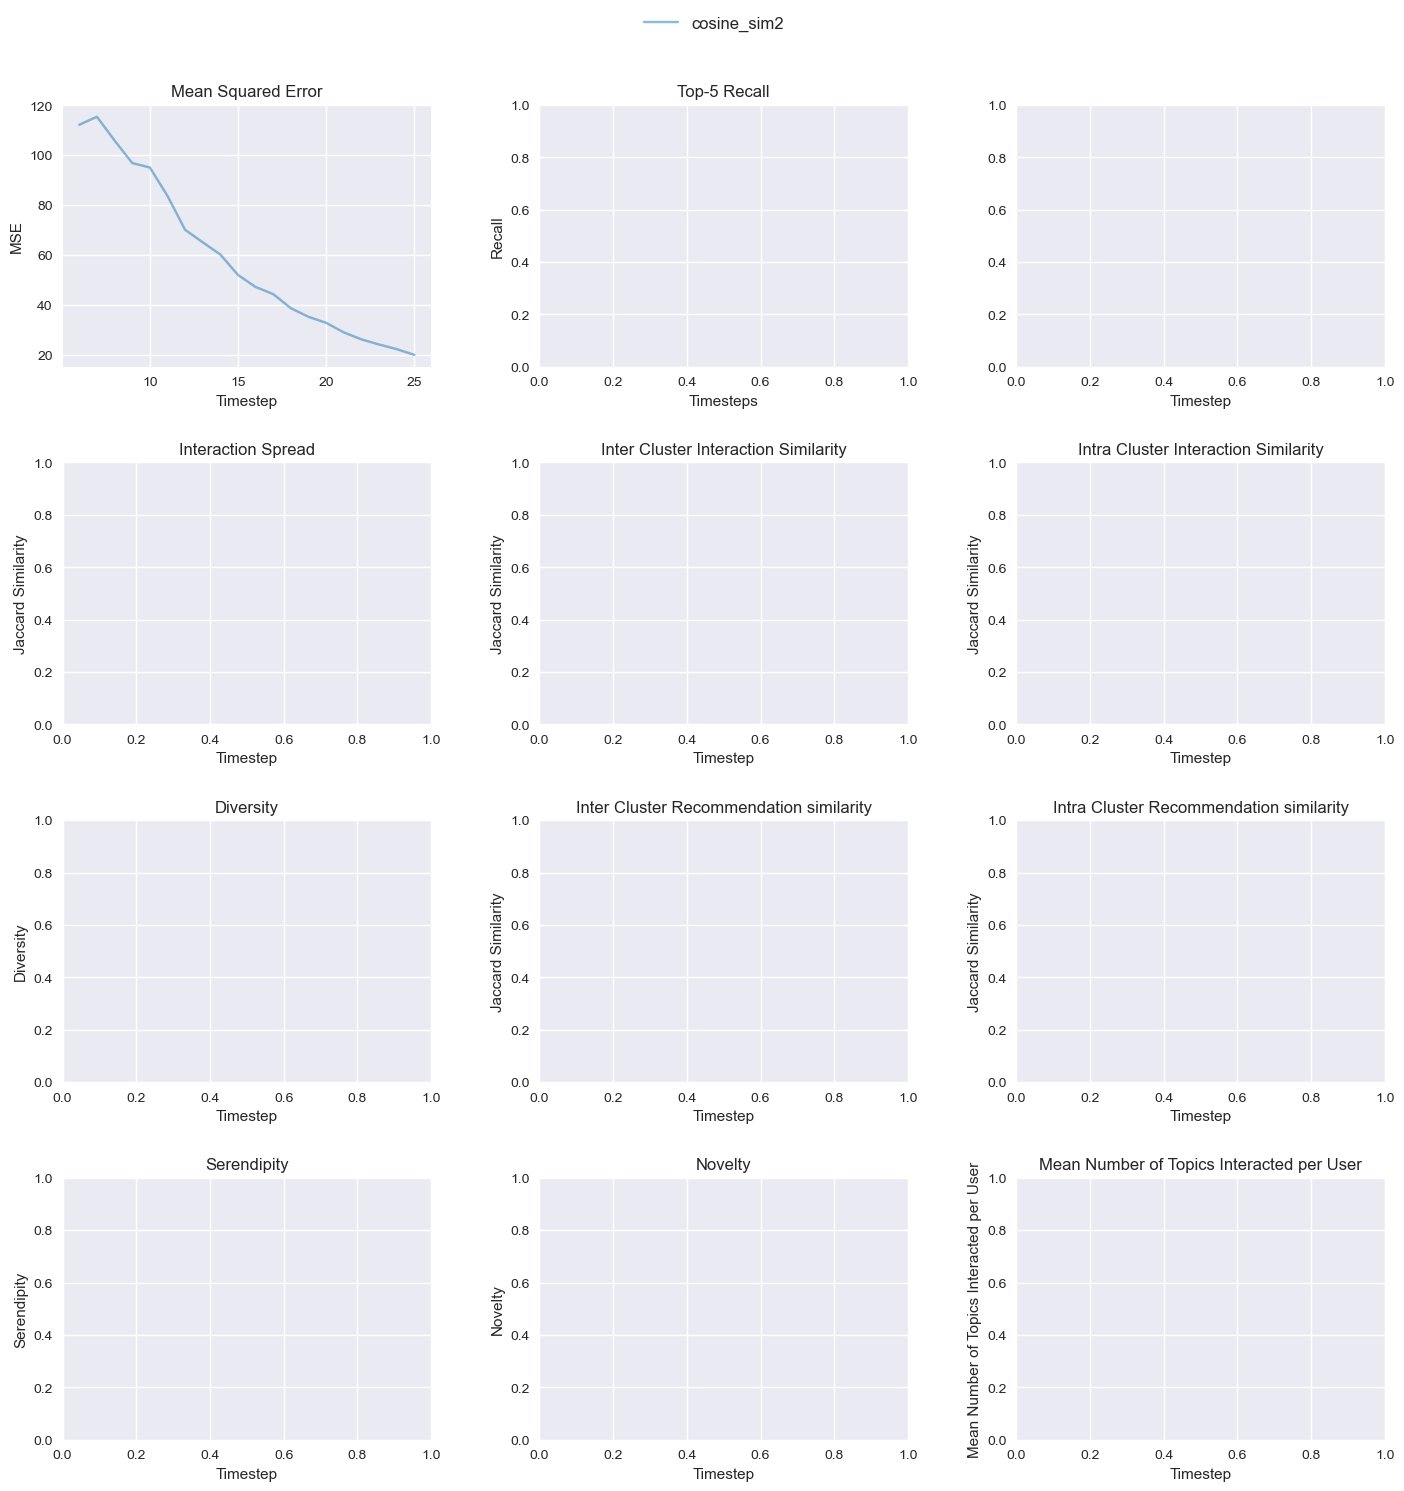

In [17]:
plot_measurements([measurements_df], parameters_df)

# Experiments

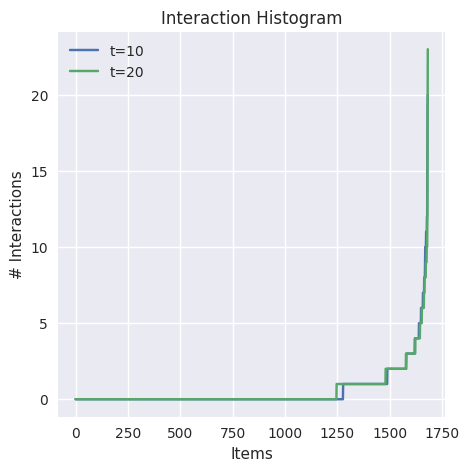

In [33]:
def plot_histograms(measurements_df):
    # for every 10 timesteps plot line in different color
    fig= plt.figure(figsize=(5, 5))
    
    timesteps = len(measurements_df)
    items = np.arange(len(measurements_df['interaction_histogram'][1]))
    for i in range(10, timesteps+1, 10):
        counts = measurements_df['interaction_histogram'][i]
        plt.plot(items, sorted(counts), label=f't={i}')

    plt.title('Interaction Histogram')
    plt.xlabel('Items')
    plt.ylabel('# Interactions')
    plt.legend()
    
plot_histograms(measurements_df)

In [44]:
recommender = model

In [19]:
# Novelty that is based on probability calculation from generate_recommendations 
# (leave previously interacted items out)
item_counts = recommender.item_count
item_counts[item_counts == 0] = 1
items_self_info = (-1) * np.log(item_counts)

# turn scores in probability distribution over items to ensure that all independent of the ranking function, the metric yields comparable values
scores = recommender.predicted_scores.value
probabilities = scores / np.sum(scores, axis=1)[:, np.newaxis]

item_indices = recommender.indices
if not recommender.users.repeat_interactions:
    # for each user, eliminate items that have been interacted with
    item_indices = item_indices[np.where(item_indices >= 0)]
    item_indices = item_indices.reshape((recommender.num_users, -1))

s_filtered = mo.to_dense(recommender.predicted_scores.filter_by_index(item_indices))
row = np.repeat(recommender.users.user_vector, item_indices.shape[1])
row = row.reshape((recommender.num_users, -1))
permutation = s_filtered.argsort()
rec = item_indices[row, permutation]
# the recommended items will not be exactly determined by
# predicted score; instead, we will sample from the sorted list
# such that higher-preference items get more probability mass
num_items_unseen = rec.shape[1]  # number of items unseen per user
probabilities = np.logspace(0.0, num_items_unseen / 10.0, num=num_items_unseen, base=2)
probabilities = probabilities / probabilities.sum()

# get utility of each item given a state of users
item_states = np.mean(probabilities, axis=0)

# calculate novelty per item by multiplying self information and utility value
item_novelties = items_self_info * item_states
# form sum over all possible items/actions
item_novelty = np.sum(item_novelties)

item_novelty

-1.8257431010368532